In [27]:
import numpy as np
from pathlib import Path
import os
import re
import h5py
import pandas as pd
import logging
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot, heatmap
from lol import LOL
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from scipy.stats import multiscale_graphcorr, ttest_rel, ttest_ind
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

import sys; sys.path.append('../')
from src.tools import get_files, get_latents, align

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datadir = Path("/mnt/ssd3/ronan/data")
unaligned_dmap_dir = datadir / f"dmap_09-04_unaligned"
aligned_dmap_dir = datadir / f"dmap_09-22_aligned"
aligned_normed_dmap_dir = datadir / f"dmap_09-23_aligned_normed"
external_dir = Path('../data/external')

In [3]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

In [ ]:
def ranked_distmat(distx):
    rank = np.argsort(distx, axis=1)

In [12]:
np.argsort(X_dists, axis=1)

array([[28, 24,  9, ..., 26, 37, 35],
       [36,  9, 44, ...,  8, 11, 49],
       [48, 11, 49, ..., 23, 39, 27],
       ...,
       [ 5, 48,  2, ..., 44,  0,  9],
       [ 7, 51,  3, ..., 13, 39, 27],
       [11, 48,  2, ..., 39, 27, 23]])

In [4]:
ALIGNED = True
NORMED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=True
)

In [5]:
group_pairs = [(0,2), (0,3), (2,3), (3,5)]
gradient = 1

In [34]:
np.argsort([0,1,2])

array([0, 1, 2])

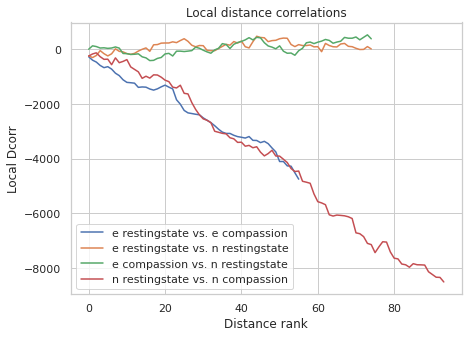

In [33]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
for i,j in group_pairs:
    l1,l2 = ' '.join(labels[i]), ' '.join(labels[j])
    g1,g2 = np.asarray(groups[i]), np.asarray(groups[j])
    
    X,Y = k_sample_transform(
        [g1, g2]
    )
    X = X[:,:,gradient]
    
    X_dists = pairwise_distances(X)
    X_dists = center_distmat(X_dists)
    Y_dists = center_distmat(pairwise_distances(Y))

    rankX = np.argsort(X_dists, axis=1)
    ranks = np.arange(X_dists.shape[0])
    dcorrs = [np.sum((rankX <= r).astype(int) * X_dists * Y_dists) for r in ranks]
    
    plt.plot(ranks, dcorrs, label=f"{l1} vs. {l2}")
    plt.xlabel('Distance rank')
    plt.ylabel('Local Dcorr')
    plt.legend()
    plt.title("Local distance correlations")